In [2]:
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.table
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from tqdm import tqdm
import emcee
import h5py

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from schwimmbad import MultiPool

from coordinates import (pal5_c, galcen_frame, 
                         pal5_lead_frame, pal5_trail_frame)

from density_1d import run_it_all

Grab coordinates of M5, and remove stars close to M5 or the Pal 5 cluster:

In [2]:
# m5_c = coord.SkyCoord.from_name('Messier 5')
m5_c = coord.SkyCoord('15 18 33.22', '+02 04 51.7', 
                      unit=(u.hourangle, u.degree))

In [3]:
ana = fits.getdata('../data/pal5_ls_lite_grz.fits')
ana_masks = fits.getdata('../data/cmd_masks_orig.fits')
ana = ana[ana_masks['gr_mask'] & ana_masks['grz_mask']]

data_c = coord.SkyCoord(ra=ana['ra'], dec=ana['dec'], unit=u.deg)
pal5_m5_mask = (data_c.separation(pal5_c) > 0.2*u.deg) & (data_c.separation(m5_c) > 0.3*u.deg)
data_c = data_c[pal5_m5_mask]

Load Ana's spatial mask around the deeper footprint:

In [4]:
mask_zlim = 23.7
mask_pts = np.load('../data/concave_hull_z{:.1f}.npz'.format(mask_zlim))['pts']
path_concavehull = mpl.path.Path(mask_pts)

_c = data_c.transform_to(gc.Pal5)
_X = np.stack((_c.phi1.degree, _c.phi2.degree)).T
deep_mask = path_concavehull.contains_points(_X)

In [5]:
with MultiPool() as pool:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tbls = run_it_all(data_c[deep_mask], 'data', pool=pool)

  0%|          | 0/11 [00:00<?, ?it/s]

running measurements for 'lead'


/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:126: RuntimeWarning: invalid value encountered in log
  6*c*phi2_max + 3*b*phi2_max**2 + 2*a*phi2_max**3)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:127: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:126: RuntimeWarning: invalid value encountered in log
  6*c*phi2_max + 3*b*phi2_max**2 + 2*a*phi2_max**3)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:127: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:126: RuntimeWarning: invalid value encountered in log
  6*c*phi2_max + 3*b*phi2_max**2 + 2*a*phi2_max**3)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:127: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sB

running measurements for 'trail'


100%|██████████| 22/22 [15:12<00:00, 38.19s/it]


In [24]:
# output
tlead = Table(np.zeros((len(tbls['lead']),13)),names=('phi1','phi2','phi2_em','phi2_ep','w','w_em','w_ep',
                                                       'f','f_em','f_ep','n','n_em','n_ep'))
ttrail = Table(np.zeros((len(tbls['trail']),13)),names=('phi1','phi2','phi2_em','phi2_ep','w','w_em','w_ep',
                                                       'f','f_em','f_ep','n','n_em','n_ep'))
# ttrail = Table(names=('phi1','phi2','phi2_em','phi2_ep','w','w_em','w_ep','f','f_em','f_ep','n','n_em','n_ep'))
tout = {'lead': tlead, 'trail': ttrail}

lead 11 11
trail 22 22


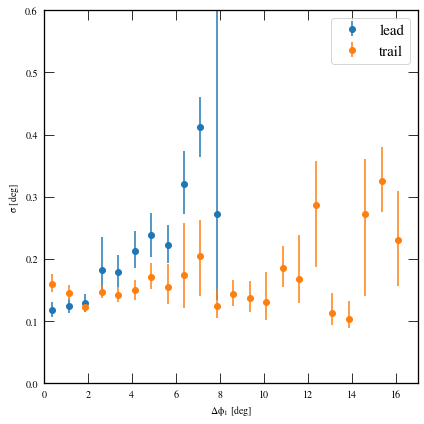

In [25]:
fig = plt.figure(figsize=(6, 6))

for name in tbls.keys():
    tbl = tbls[name]
    med = np.median(tbl['std_s'], axis=1)
    err1 = med - np.percentile(tbl['std_s'], 16, axis=1)
    err2 = np.percentile(tbl['std_s'], 84, axis=1) - med
    plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=name)
    
    tout[name]['phi1'] = tbl['phi1_c']
    tout[name]['w'] = med
    tout[name]['w_em'] = err1
    tout[name]['w_ep'] = err2
    
plt.legend(loc='best', fontsize=15)
    
plt.xlim(0, 17)
plt.xticks(np.arange(0, 16+1e-3, 2))
plt.ylim(0, 0.6)

plt.xlabel(r'$\Delta \phi_1$ [deg]')
plt.ylabel(r'$\sigma$ [deg]')
fig.set_facecolor('w')
fig.tight_layout()

# fig.savefig('../plots/density-1d-width.png', dpi=250)

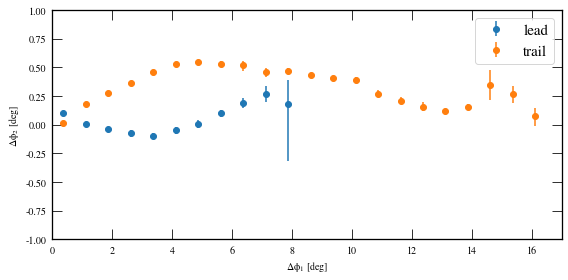

In [26]:
fig = plt.figure(figsize=(8,4))

for name in tbls.keys():
    tbl = tbls[name]
    med = np.median(tbl['mu_s'], axis=1)
    err1 = med - np.percentile(tbl['mu_s'], 16, axis=1)
    err2 = np.percentile(tbl['mu_s'], 84, axis=1) - med
    
    tout[name]['phi2'] = med
    tout[name]['phi2_em'] = err1
    tout[name]['phi2_ep'] = err2
    
    plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=name)
plt.legend(loc='best', fontsize=15)
    
plt.xlim(0, 17)
plt.ylim(-1, 1)
plt.xticks(np.arange(0, 16+1e-3, 2))

plt.xlabel(r'$\Delta \phi_1$ [deg]')
plt.ylabel('$\Delta \phi_2$ [deg]')
fig.set_facecolor('w')
fig.tight_layout()

# fig.savefig('../plots/density-1d-track.png', dpi=250)

Text(0, 0.5, '$f$')

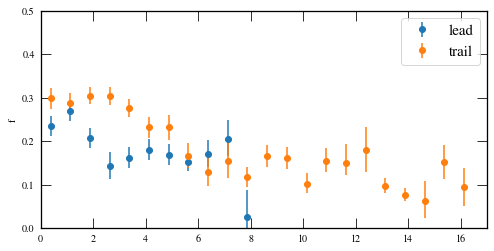

In [27]:
plt.figure(figsize=(8, 4))
for name in tbls.keys():
    tbl = tbls[name]
    med = np.median(tbl['a'], axis=1)
    err1 = med - np.percentile(tbl['a'], 16, axis=1)
    err2 = np.percentile(tbl['a'], 84, axis=1) - med
    
    tout[name]['f'] = med
    tout[name]['f_em'] = err1
    tout[name]['f_ep'] = err2
    
    plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=name)

plt.legend(loc='best', fontsize=15)

plt.xlim(0, 17)
plt.ylim(0, 0.5)
plt.xticks(np.arange(0, 16+1e-3, 2))

plt.ylabel('$f$')

# fig.savefig('../plots/density-1d-f.png', dpi=250)

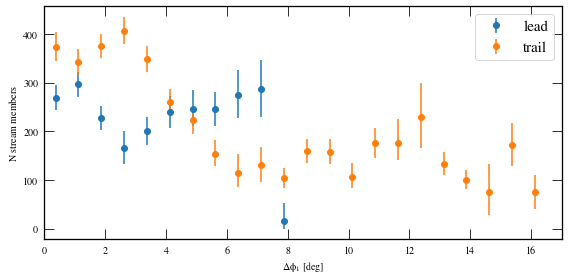

In [28]:
fig = plt.figure(figsize=(8,4))

for name in tbls.keys():
    tbl = tbls[name]
    val = tbl['a'] * tbl['N'][:, None]
    med = np.median(val, axis=1)
    err1 = med - np.percentile(val, 16, axis=1)
    err2 = np.percentile(val, 84, axis=1) - med
    
    tout[name]['n'] = med
    tout[name]['n_em'] = err1
    tout[name]['n_ep'] = err2
    
    plt.errorbar(tbl['phi1_c'], med, yerr=(err1, err2),
                 ls='none', marker='o', label=name)
    
plt.legend(loc='best', fontsize=15)
    
plt.xlim(0, 17)
# plt.ylim(0, 0.25)
plt.xticks(np.arange(0, 16+1e-3, 2))

plt.xlabel(r'$\Delta \phi_1$ [deg]')
plt.ylabel('$N$ stream members')
fig.set_facecolor('w')
fig.tight_layout()

# fig.savefig('../plots/density-1d-N.png', dpi=250)

In [40]:
pal5_lead_frame

<GreatCircleICRSFrame Frame (pole=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, )
    (319.15720277, -43.9537228, 1.)>, center=None, ra0=229.02645109910873 deg, rotation=0.0 deg)>

In [41]:
# convert to the same reference frame
cl = gc.GreatCircleICRSFrame(phi1=tlead['phi1']*u.deg, phi2=tlead['phi2']*u.deg,
                             pole=pal5_lead_frame.pole, ra0=pal5_lead_frame.ra0)
ct = gc.GreatCircleICRSFrame(phi1=ttrail['phi1']*u.deg, phi2=ttrail['phi2']*u.deg,
                             pole=pal5_trail_frame.pole, ra0=pal5_trail_frame.ra0)
cl_pal5 = cl.transform_to(gc.Pal5PriceWhelan18)
ct_pal5 = ct.transform_to(gc.Pal5PriceWhelan18)

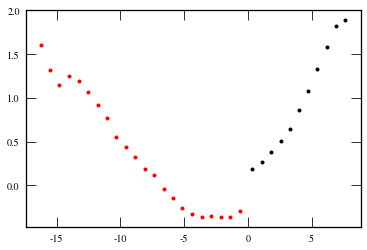

In [42]:
plt.plot(cl_pal5.phi1, cl_pal5.phi2, 'k.')
plt.plot(ct_pal5.phi1, ct_pal5.phi2, 'r.')

In [49]:
tlead['phi1'] = cl_pal5.phi1.deg
tlead['phi2'] = cl_pal5.phi2.deg
ttrail['phi1'] = ct_pal5.phi1.deg
ttrail['phi2'] = ct_pal5.phi2.deg

In [51]:
tcomb = astropy.table.vstack([tlead, ttrail])

In [53]:
tcomb.write('../data/combined_params_1d.fits')

## Fit 1D profiles of simulated streams

In [3]:
# read in models
files = []
names = ['reg_orb.hdf5', 'chaotic_orb.hdf5', 'BarModels_RL1_Mb5e+09_Om38.0.hdf5',
         'BarModels_RL1_Mb1e+10_Om45.0.hdf5']
ceqmod = []

for e, name in enumerate(names):
    f = h5py.File('../data/{:s}'.format(name), 'r')
    files += [f]
    cgal = coord.Galactocentric(x=f['pos'][0]*u.kpc, y=f['pos'][1]*u.kpc, z=f['pos'][2]*u.kpc)
    ceq = cgal.transform_to(coord.ICRS)
    ceqmod += [ceq]

In [5]:
mod_names = ['regular', 'chaotic', 'bar_slow', 'bar_fast']

In [18]:
ceqmod[0]

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    [(248.5802116 ,   8.00795592, 22.1856622 ),
     (220.50169307, -12.23889793, 18.64402503),
     (235.48553942,   3.50167338, 23.33720283), ...,
     (229.50012275,  -0.63456542, 22.50346585),
     (229.30596374,  -0.43831791, 22.74914736),
     (229.40495   ,  -0.4730804 , 22.45670427)]>

In [4]:
with MultiPool() as pool:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tbls = run_it_all(ceqmod[0], mod_names[0], pool=pool)

  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'lead'


/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:128: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:127: RuntimeWarning: invalid value encountered in log
  6*c*phi2_max + 3*b*phi2_max**2 + 2*a*phi2_max**3)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:128: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:127: RuntimeWarning: invalid value encountered in log
  6*c*phi2_max + 3*b*phi2_max**2 + 2*a*phi2_max**3)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:128: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:128: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBigges

running measurements for 'trail'


100%|██████████| 26/26 [02:48<00:00, 30.06s/it] 


In [6]:
# output
tlead = Table(np.zeros((len(tbls['lead']),13)),names=('phi1','phi2','phi2_em','phi2_ep','w','w_em','w_ep',
                                                       'f','f_em','f_ep','n','n_em','n_ep'))
ttrail = Table(np.zeros((len(tbls['trail']),13)),names=('phi1','phi2','phi2_em','phi2_ep','w','w_em','w_ep',
                                                       'f','f_em','f_ep','n','n_em','n_ep'))
tout = {'lead': tlead, 'trail': ttrail}

In [7]:
colnames = {'std_s': 'w', 'mu_s': 'phi2', 'a': 'f'}

In [8]:
for name in tbls.keys():
    tbl = tbls[name]
    tout[name]['phi1'] = tbl['phi1_c']
    
    val = tbl['a'] * tbl['N'][:, None]
    med = np.median(val, axis=1)
    err1 = med - np.percentile(val, 16, axis=1)
    err2 = np.percentile(val, 84, axis=1) - med
    tout[name]['n'] = med
    tout[name]['n_em'] = err1
    tout[name]['n_ep'] = err2

    for k in colnames:
        med = np.median(tbl[k], axis=1)
        err1 = med - np.percentile(tbl[k], 16, axis=1)
        err2 = np.percentile(tbl[k], 84, axis=1) - med
        tout[name]['{:s}'.format(colnames[k])] = med
        tout[name]['{:s}_em'.format(colnames[k])] = err1
        tout[name]['{:s}_ep'.format(colnames[k])] = err2

In [10]:
# convert to the same reference frame
cl = gc.GreatCircleICRSFrame(phi1=tlead['phi1']*u.deg, phi2=tlead['phi2']*u.deg,
                             pole=pal5_lead_frame.pole, ra0=pal5_lead_frame.ra0)
ct = gc.GreatCircleICRSFrame(phi1=ttrail['phi1']*u.deg, phi2=ttrail['phi2']*u.deg,
                             pole=pal5_trail_frame.pole, ra0=pal5_trail_frame.ra0)
cl_pal5 = cl.transform_to(gc.Pal5PriceWhelan18)
ct_pal5 = ct.transform_to(gc.Pal5PriceWhelan18)

tlead['phi1'] = cl_pal5.phi1.deg
tlead['phi2'] = cl_pal5.phi2.deg
ttrail['phi1'] = ct_pal5.phi1.deg
ttrail['phi2'] = ct_pal5.phi2.deg

In [11]:
tcomb = astropy.table.vstack([tlead, ttrail])
tcomb.write('../data/combined_params_1d_{:s}.fits'.format(mod_names[0]))

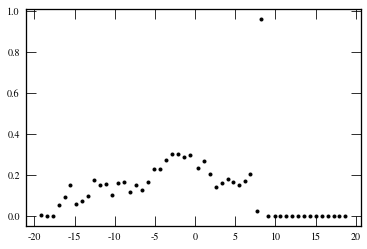

In [16]:
plt.plot(tcomb['phi1'], tcomb['f'], 'k.')

In [20]:
# run subsequent models
for i in range(0,1):
    with MultiPool() as pool:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tbls = run_it_all(ceqmod[i], mod_names[i], pool=pool)
    
    # output tables
    tlead = Table(np.zeros((len(tbls['lead']),13)),names=('phi1','phi2','phi2_em','phi2_ep','w','w_em','w_ep',
                                                           'f','f_em','f_ep','n','n_em','n_ep'))
    ttrail = Table(np.zeros((len(tbls['trail']),13)),names=('phi1','phi2','phi2_em','phi2_ep','w','w_em','w_ep',
                                                           'f','f_em','f_ep','n','n_em','n_ep'))
    tout = {'lead': tlead, 'trail': ttrail}
    
    # extract median and uncertainties in properties along the stream
    for name in tbls.keys():
        tbl = tbls[name]
        tout[name]['phi1'] = tbl['phi1_c']

        val = tbl['a'] * tbl['N'][:, None]
        med = np.median(val, axis=1)
        err1 = med - np.percentile(val, 16, axis=1)
        err2 = np.percentile(val, 84, axis=1) - med
        tout[name]['n'] = med
        tout[name]['n_em'] = err1
        tout[name]['n_ep'] = err2

        for k in colnames:
            med = np.median(tbl[k], axis=1)
            err1 = med - np.percentile(tbl[k], 16, axis=1)
            err2 = np.percentile(tbl[k], 84, axis=1) - med
            tout[name]['{:s}'.format(colnames[k])] = med
            tout[name]['{:s}_em'.format(colnames[k])] = err1
            tout[name]['{:s}_ep'.format(colnames[k])] = err2
    
    # convert to the same reference frame
    cl = gc.GreatCircleICRSFrame(phi1=tlead['phi1']*u.deg, phi2=tlead['phi2']*u.deg,
                                 pole=pal5_lead_frame.pole, ra0=pal5_lead_frame.ra0)
    ct = gc.GreatCircleICRSFrame(phi1=ttrail['phi1']*u.deg, phi2=ttrail['phi2']*u.deg,
                                 pole=pal5_trail_frame.pole, ra0=pal5_trail_frame.ra0)
    cl_pal5 = cl.transform_to(gc.Pal5PriceWhelan18)
    ct_pal5 = ct.transform_to(gc.Pal5PriceWhelan18)

    tlead['phi1'] = cl_pal5.phi1.deg
    tlead['phi2'] = cl_pal5.phi2.deg
    ttrail['phi1'] = ct_pal5.phi1.deg
    ttrail['phi2'] = ct_pal5.phi2.deg
    
    # write table
    tcomb = astropy.table.vstack([tlead, ttrail])
    tcomb.write('../data/combined_params_1d_{:s}.fits'.format(mod_names[i]), overwrite=True)

  0%|          | 0/26 [00:00<?, ?it/s]

running measurements for 'lead'


/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:128: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:128: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:127: RuntimeWarning: invalid value encountered in log
  6*c*phi2_max + 3*b*phi2_max**2 + 2*a*phi2_max**3)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:127: RuntimeWarning: invalid value encountered in log
  6*c*phi2_max + 3*b*phi2_max**2 + 2*a*phi2_max**3)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:128: RuntimeWarning: invalid value encountered in log
  bg_ll = lnA + np.log(a*phi2**2 + b*phi2 + c)
/home/ana/projects/Pal5sBiggestFan/notebooks/density_1d.py:127: RuntimeWarning: invalid value encountered in log
  6*c*phi2_max + 3*b*phi2_max**2 + 2*a*phi2_max**3)
/home/ana/projects/Pal5sB

running measurements for 'trail'


100%|██████████| 26/26 [21:34<00:00, 46.39s/it]


OSError: File exists: ../data/combined_params_1d_regular.fits

In [21]:
tcomb.write('../data/combined_params_1d_{:s}.fits'.format(mod_names[0]), overwrite=True)